In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import WindowDataset
import CustomModels
import CustomMetrics
import CustomWindowGenerator

%load_ext autoreload
%autoreload 2

# DATASET

## Load Dataset

In [2]:
data_horaria_estandarizada_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Horaria_Estandarizada.xlsx')
data_horaria_estandarizada = pd.read_excel(data_horaria_estandarizada_path)
data_horaria_estandarizada = data_horaria_estandarizada.set_index('Fecha')

In [3]:
precio_bolsa_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Precio_Bolsa_Estandarizada.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

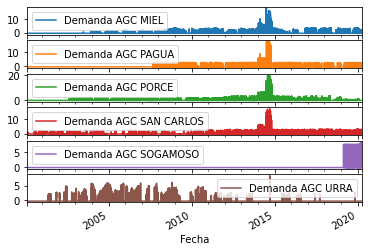

In [4]:
plot_cols = data_horaria_estandarizada.columns[-6:]
plot_features = data_horaria_estandarizada[plot_cols]
_ = plot_features.plot(subplots=True)

In [5]:
full_df = pd.concat([data_horaria_estandarizada,precio_bolsa],axis=1)
full_df.shape,data_horaria_estandarizada.shape,precio_bolsa.shape

((176760, 85), (176760, 84), (176760, 1))

In [6]:
train_df = full_df[(full_df.index >= '2000-01-01') & (full_df.index < '2019-01-01')]
val_df = full_df[(full_df.index >= '2019-01-01') & (full_df.index < '2020-01-01')]
test_df = full_df[full_df.index >= '2019-12-31']

train_df.shape,val_df.shape,test_df.shape

((165816, 85), (8760, 85), (2208, 85))

## Build Window

In [7]:
inputs_columns = ['Generacion ALBAN', 'Generacion BETANIA', 'Generacion CHIVOR',
          'Generacion EL QUIMBO', 'Generacion GUATAPE', 'Generacion GUATRON',
          'Generacion GUAVIO', 'Generacion LA TASAJERA', 'Generacion MIEL',
          'Generacion PAGUA', 'Generacion PLAYAS', 'Generacion PORCE',
          'Generacion SAN CARLOS', 'Generacion SOGAMOSO', 'Generacion URRA','$kWh']
output_columns = inputs_columns

#inputs_columns = ['$kWh']
#output_columns = ['$kWh']

In [8]:
window_train = CustomWindowGenerator.MyWindowDatasetGenerator(data=train_df, times=24, shift=1,
                                                              input_signals=inputs_columns, output_signals=output_columns)

train_generator = window_train.make_dataset(train_df,batch_size=16,suffle=True)

In [9]:
window_val = CustomWindowGenerator.MyWindowDatasetGenerator(data=val_df, times=24, shift=1,
                                                            input_signals=inputs_columns, output_signals=output_columns)

val_generator = window_val.make_dataset(val_df,batch_size=16,suffle=True)

In [10]:
window_test = CustomWindowGenerator.MyWindowDatasetGenerator(data=test_df, times=24, shift=24,
                                                             input_signals=inputs_columns, output_signals=output_columns)

test_generator = window_test.make_dataset(test_df,batch_size=16,suffle=False,sequence_stride=24)

# MODELS

## Instantiate Models

In [11]:
custom_rnn  = CustomModels.CustomRNN(rnn_units=90,output_units=len(output_columns))
custom_lstm = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
custom_gru  = CustomModels.CustomGRU(gru_units=90,output_units=len(output_columns))
custom_cnn  = CustomModels.CustomCNN(dropout_rate=0.31,output_units=len(output_columns))

## Instantiate metrics dicts

In [12]:
val_performance = dict()
performance = dict()

## Compile & Fit Method

In [13]:
def compile_and_fit(model, window_train, window_val, epochs, steps_per_epoch, val_steps,patience):
    """
    Este método se encarga de definir las funciones Callback, compilar y además realizar entrenar
    el modelo. Entre las funciones Callback que se definen aquí están: Logs de TensorBoard, Redu-
    cción del Learning Rate cuando la métrica se queda estancada y Frenado del proceso de  entre-
    namient.
    Input:
        - model: Estimador que se va a entrenar.
        - window_train: Generador de datos con el cual se va a entrenar.
        - window_val: Generador de datos con el cual se va a evaluar.
        - epochs: Entero con las épocas de entrenamiento.
        - steps_per_epoch: Entero con la cantidad de pasos por época.
        - val_steps: Entero con los pasos por época para evaluación.
        - patience: Entero que determina cuantas epocas pasaran antes de ejecutar una acción del
        callback.
    Output:
        - history: Diccionario con los resultados del entrenamiento del modelo.
    """
    log_dir = os.path.join('logs',model.name)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=2,
                                                          write_graph=False,
                                                          update_freq='epoch')
    
    callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                              factor=0.1,
                                                              min_lr=1e-4,
                                                              patience=0,
                                                              verbose=1)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
    callbacks = [callback_tensorboard,callback_reduce_lr,early_stopping]
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanAbsolutePercentageError(),
                           CustomMetrics.symmetric_mean_absolute_percentage_error])
    
    history = model.fit(x=window_train,epochs=epochs,steps_per_epoch=steps_per_epoch,
              validation_data=window_val,validation_steps=val_steps,callbacks=callbacks)
    
    return history

## Predictions & Plot

In [14]:
def generate_predictions_style_1(inputs,labels,model):
    batch_predictions = list()
    for batch in inputs:

        flat_inputs_size = batch.shape[0]
        num_inputs_signals = batch.shape[1]
        num_labels_signals = labels.shape[2]

        predicted_signal = list()
        predicted_signal_idx = 0

        for i in range(0,flat_inputs_size):

            first_signals = tf.reshape(batch[i:24,:], [-1,num_inputs_signals])
            last_signals = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,num_labels_signals])
            
            signals_to_predict = tf.concat([first_signals,last_signals],axis=0)

            signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)

            predictions = model.predict(signals_to_predict)
            predicted_signal.append(predictions)

        batch_predictions.append(predicted_signal)

    batch_predictions = tf.reshape(tf.convert_to_tensor(batch_predictions),labels.shape)
    return batch_predictions

In [15]:
def plot_comparison(inputs,predictions):
    signal_true = inputs[:,:,-1]
    flat_signal_true = tf.reshape(signal_true, [-1,1])

    signal_pred = predictions[:,:,-1]
    flat_signal_pred = tf.reshape(signal_pred, [-1,1])

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(flat_signal_true, label='true')
    plt.plot(flat_signal_pred, label='pred')

    plt.ylabel('Precio en Bolsa Nacional')
    plt.legend()
    plt.show()

In [16]:
def find_metrics_test(y_true,y_pred):
    
    mae_call = tf.keras.metrics.MeanAbsoluteError()
    mae_call.update_state(y_true,y_pred)
    mae = mae_call.result().numpy()
    
    mape_call = tf.keras.metrics.MeanAbsolutePercentageError()
    mape_call.update_state(y_true,y_pred)
    mape = mape_call.result().numpy()
    
    sMAPE_call = CustomMetrics.symmetric_mean_absolute_percentage_error(y_true,y_pred)
    sMAPE = sMAPE_call.numpy()
    
    return [mae,mape,sMAPE]

## Execute experiments

### Recurrent Neuronal Network

In [17]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomRNN(rnn_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 83)                8300      
_________________________________________________________________
dense (Dense)                (None, 16)                1344      
Total params: 9,644
Trainable params: 9,644
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = compile_and_fit(model=custom_rnn, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
  1/300 [..............................] - ETA: 0s - loss: 2.0684 - mean_absolute_error: 1.1134 - mean_absolute_percentage_error: 192.5172 - symmetric_mean_absolute_percentage_error: 36786.1133WARNING:tensorflow:From C:\Users\SEBASTIAN\anaconda3\envs\proyecto-grados\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
300/300 [==============================] - 8s 28ms/step - loss: 1.0264 - mean_absolute_error: 0.8093 - mean_absolute_percentage_error: 187.3478 - symmetric_mean_absolute_percentage_error: 41447.1484 - val_loss: 1.2773 - val_mean_absolute_error: 0.9503 - val_mean_absolute_percentage_error: 193.6582 - val_symmetric_mean_absolute_percentage_error: 43850.0898
Epoch 2/100
298/300 [============================>.] - ETA: 0s - loss: 0.9767 - mean_absolute_error: 0.7923 - mean_absolute_percen

In [19]:
val_performance['DNN'] = custom_rnn.evaluate(val_generator)

546/546 [==============================] - 2s 4ms/step - loss: 1.2724 - mean_absolute_error: 0.9507 - mean_absolute_percentage_error: 140.4285 - symmetric_mean_absolute_percentage_error: 46172.3516


In [20]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

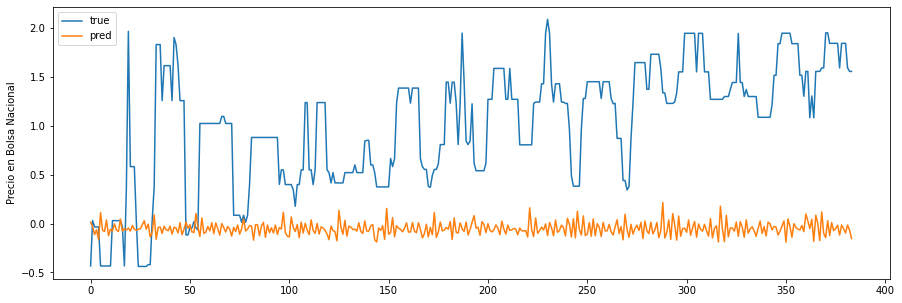

In [21]:
predictions = generate_predictions_style_1(inputs,labels,custom_rnn)
plot_comparison(labels,predictions)

In [22]:
performance['RNN'] = find_metrics_test(labels,predictions)

### Long Short Term Memory

In [23]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 83)                33200     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1344      
Total params: 34,544
Trainable params: 34,544
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = compile_and_fit(model=custom_lstm, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 5s 17ms/step - loss: 0.9843 - mean_absolute_error: 0.7958 - mean_absolute_percentage_error: 131.5378 - symmetric_mean_absolute_percentage_error: 44185.4766 - val_loss: 1.2673 - val_mean_absolute_error: 0.9466 - val_mean_absolute_percentage_error: 143.6759 - val_symmetric_mean_absolute_percentage_error: 45989.4336
Epoch 2/100
300/300 [==============================] - 3s 9ms/step - loss: 0.9614 - mean_absolute_error: 0.7882 - mean_absolute_percentage_error: 114.3611 - symmetric_mean_absolute_percentage_error: 44264.4180 - val_loss: 1.2204 - val_mean_absolute_error: 0.9344 - val_mean_absolute_percentage_error: 158.1024 - val_symmetric_mean_absolute_percentage_error: 45416.4023
Epoch 3/100
297/300 [============================>.] - ETA: 0s - loss: 0.9666 - mean_absolute_error: 0.7893 - mean_absolute_percentage_error: 163.4611 - symmetric_mean_absolute_percentage_error: 44313.0977
Epoch 00003: ReduceLROnPlateau reducing learning rate t

In [25]:
val_performance['LSTM'] = custom_lstm.evaluate(val_generator)

546/546 [==============================] - 3s 5ms/step - loss: 1.2653 - mean_absolute_error: 0.9496 - mean_absolute_percentage_error: 126.6584 - symmetric_mean_absolute_percentage_error: 47007.3438


In [26]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

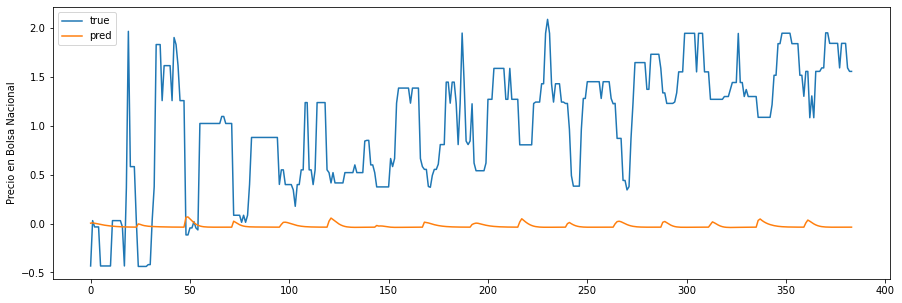

In [27]:
predictions = generate_predictions_style_1(inputs,labels,custom_lstm)
plot_comparison(labels,predictions)

In [28]:
performance['LSTM'] = find_metrics_test(labels,predictions)

### Gated Recurrent Unit

In [29]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomGRU(gru_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_gru_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 83)                25149     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1344      
Total params: 26,493
Trainable params: 26,493
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = compile_and_fit(model=custom_gru, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 26s 88ms/step - loss: 0.9901 - mean_absolute_error: 0.7978 - mean_absolute_percentage_error: 138.1729 - symmetric_mean_absolute_percentage_error: 43985.5234 - val_loss: 1.2617 - val_mean_absolute_error: 0.9468 - val_mean_absolute_percentage_error: 141.7778 - val_symmetric_mean_absolute_percentage_error: 46442.9062
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.9622 - mean_absolute_error: 0.7878 - mean_absolute_percentage_error: 117.3002 - symmetric_mean_absolute_percentage_error: 43909.5195
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
300/300 [==============================] - 24s 79ms/step - loss: 0.9622 - mean_absolute_error: 0.7878 - mean_absolute_percentage_error: 117.3002 - symmetric_mean_absolute_percentage_error: 43909.5195 - val_loss: 1.2831 - val_mean_absolute_error: 0.9504 - val_mean_absolute_percentage_error: 150.2303 - val_symmetric_mean_absolute_percentage_e

In [31]:
val_performance['GRU'] = custom_gru.evaluate(val_generator)

546/546 [==============================] - 4s 7ms/step - loss: 1.2648 - mean_absolute_error: 0.9494 - mean_absolute_percentage_error: 130.2290 - symmetric_mean_absolute_percentage_error: 46750.1680


In [32]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

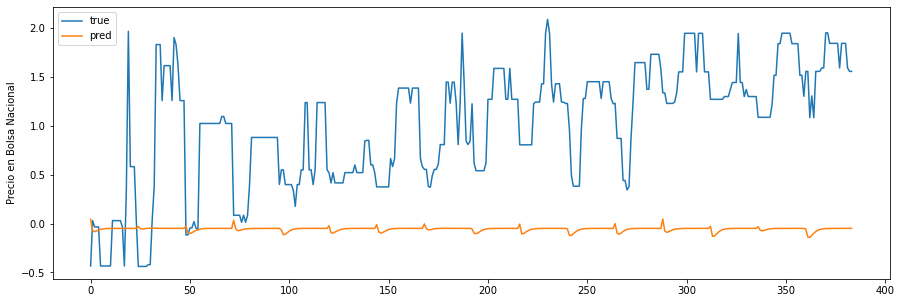

In [33]:
predictions = generate_predictions_style_1(inputs,labels,custom_gru)
plot_comparison(labels,predictions)

In [34]:
performance['GRU'] = find_metrics_test(labels,predictions)

### Convolutional Neuronal Network

In [35]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomCNN(dropout_rate=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            2112      
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 23, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)               

In [36]:
history = compile_and_fit(model=custom_cnn, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 5s 16ms/step - loss: 1.2708 - mean_absolute_error: 0.8865 - mean_absolute_percentage_error: 328.6715 - symmetric_mean_absolute_percentage_error: 37635.0273 - val_loss: 1.3621 - val_mean_absolute_error: 0.9736 - val_mean_absolute_percentage_error: 222.3086 - val_symmetric_mean_absolute_percentage_error: 43447.5547
Epoch 2/100
300/300 [==============================] - 3s 9ms/step - loss: 1.0495 - mean_absolute_error: 0.8156 - mean_absolute_percentage_error: 173.6712 - symmetric_mean_absolute_percentage_error: 39769.1914 - val_loss: 1.3209 - val_mean_absolute_error: 0.9617 - val_mean_absolute_percentage_error: 176.9423 - val_symmetric_mean_absolute_percentage_error: 45155.4609
Epoch 3/100
300/300 [==============================] - 3s 10ms/step - loss: 1.0009 - mean_absolute_error: 0.8009 - mean_absolute_percentage_error: 254.2385 - symmetric_mean_absolute_percentage_error: 41493.4219 - val_loss: 1.2915 - val_mean_absolute_error: 0.95

In [37]:
val_performance['CNN'] = custom_cnn.evaluate(val_generator)

546/546 [==============================] - 2s 4ms/step - loss: 1.2984 - mean_absolute_error: 0.9594 - mean_absolute_percentage_error: 121.4411 - symmetric_mean_absolute_percentage_error: 47931.8438


In [38]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

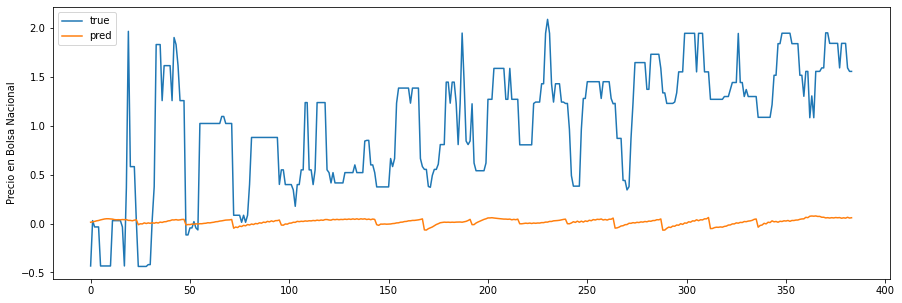

In [39]:
predictions = generate_predictions_style_1(inputs,labels,custom_cnn)
plot_comparison(labels,predictions)

In [40]:
performance['CNN'] = find_metrics_test(labels,predictions)

## Metrics Summary

In [41]:
pd.DataFrame(val_performance,index=['Loss','Mean Absolute Error',
                                    'Mean Absolute Percentage Error',
                                    'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,1.272395,0.95075,140.428513,46172.351562
LSTM,1.265293,0.94957,126.658394,47007.343750
GRU,1.264836,0.94939,130.228973,46750.167969
CNN,1.298383,0.95943,121.441063,47931.843750


In [42]:
pd.DataFrame(performance,index=['Mean Absolute Error',
                                'Mean Absolute Percentage Error',
                                'Symetric Mean Absolute Percentage Error']).T

,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
RNN,0.993186,114.491524,70797.540283
LSTM,0.986965,107.475502,74137.145996
GRU,0.989374,109.043724,74294.982910
CNN,0.985224,107.397850,73019.616699
